## Deep Learning Data Uncertainty

This notebook introduces the data uncertainty into the neural network by defining a worst and best-case scenario along with the expected result. Experiment #1 statically introduces different scenarios while Experiment #2 makes use of random sampling of a normal distribution to introduce and additional layer of uncertainty. 

Note: the experiments are performed on the test set only. 

In [1]:
#importing necessary packages
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Input
import pandas as pd
import numpy as np
import random
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from keras.backend import clear_session
from keras.layers import Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.backend import clear_session
from keras.layers import Dense, Activation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

In [2]:
#setting the seed for reproducibility
cross_validation = KFold(n_splits = 3, shuffle = True, random_state = 10)

seed = 14
tf.random.set_seed(14)

In [3]:
#checking if GPU is being used 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 170568237621927764
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15513944064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16096969835633213042
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
#read dataframe from the Data Preparation Notebook 
import pandas as pd
df_complete3 = pd.read_pickle('df_complete3_v3.pickle')

In [5]:
#change types of the whole dataframe so that we do not run out of memory during the training process 
df_complete3 = df_complete3.astype(np.uint8)

In [6]:
df_complete3.shape

(100040, 45)

In [7]:
#split off target column
target_column = df_complete3['number of conflicts']
df_complete3.drop(columns = ['number of conflicts'], inplace = True)

In [8]:
#perform train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_complete3, target_column, test_size = 0.08, random_state = 0)


#### Experiment #1

In [9]:
test_df_low = X_test.copy()
test_df_high = X_test.copy()

In [10]:
numeric_predictors = ['gender development index (GDI)', 'human development index (HDI)',
       'health index', 'income index', 'educational index',
       'expected years of schooling', 'mean years of scholing',
       'life expectancy', "GNI per capita (000'000)",
       "population (000'000)",
       'Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Consumer price index (2010 = 100)',
       'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
       'GDP (constant 2015 US$)', 'GDP per capita (constant 2015 US$)',
       'Oil rents (% of GDP)',
       'Refugee population by country or territory of asylum',
       'Rural population (% of total population)',
       'Unemployment, female (% of female labor force) (modeled ILO estimate)',
       'Unemployment, male (% of male labor force) (modeled ILO estimate)',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)']

In [11]:
#create lower bound
#test_df_high = X_test.copy()
for column in test_df_low:
    if column in numeric_predictors: 
        test_df_low[column] = test_df_low[column]*0.95
#test_df_high = sc.transform(test_df_high)

In [12]:
#create upper bound 
for column in test_df_high:
    if column in numeric_predictors: 
        test_df_high[column] = test_df_high[column]*1.05

In [13]:
#now we apply the standard scaler
#normalize the data with a StandardScaler - performance regarding simple model is better, so we continue with the Standard Scaler!
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [14]:
#apply the standard scaler to the max and min transformed data
test_df_high = sc.transform(test_df_high)
test_df_low = sc.transform(test_df_low)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [15]:
#now we train the best neural network 
#now scaling!
#taking the best model - with relu and normal
def wider_larger_model(dropout_rate, weight_constraint):
    clear_session()
    model = Sequential()
    del model
    model = Sequential()
    
    model.add(Dense(40, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(30, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error')
    return model

In [16]:
#increase epochs to 100 with best model
# Function to create model, required for KerasClassifier
# create model
model = KerasRegressor(model=wider_larger_model, verbose=2, epochs = 50, batch_size = 2000, optimizer = "Adam",
                      optimizer__learning_rate = 0.1, loss = 'mean_squared_error')

# define the grid search parameters
weight_constraint = [4]
dropout_rate = [0.0]
# Make a dictionary of the grid search parameters
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint = weight_constraint )


grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=1, cv= cross_validation, scoring = "neg_mean_squared_error")
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/200
31/31 - 3s - loss: 372.2234 - 3s/epoch - 89ms/step
Epoch 2/200
31/31 - 0s - loss: 324.9102 - 453ms/epoch - 15ms/step
Epoch 3/200
31/31 - 0s - loss: 313.6724 - 470ms/epoch - 15ms/step
Epoch 4/200
31/31 - 0s - loss: 306.4431 - 423ms/epoch - 14ms/step
Epoch 5/200
31/31 - 0s - loss: 302.3170 - 458ms/epoch - 15ms/step
Epoch 6/200
31/31 - 0s - loss: 296.8551 - 451ms/epoch - 15ms/step
Epoch 7/200
31/31 - 0s - loss: 289.6991 - 459ms/epoch - 15ms/step
Epoch 8/200
31/31 - 0s - loss: 282.9951 - 494ms/epoch - 16ms/step
Epoch 9/200
31/31 - 0s - loss: 276.5284 - 410ms/epoch - 13ms/step
Epoch 10/200
31/31 - 0s - loss: 270.5664 - 411ms/epoch - 13ms/step
Epoch 11/200
31/31 - 0s - loss: 264.3005 - 449ms/epoch - 14ms/step
Epoch 12/200
31/31 - 0s - loss: 256.9148 - 426ms/epoch - 14ms/step
Epoch 13/200
31/31 - 0s - loss: 251.3967 - 482ms/epoch - 16ms/step
Epoch 14/200
31/31 - 0s - loss: 247.1920 - 479ms/epoch - 15ms/step
Epoch 15/200
31/31 - 0s - loss: 242.8409 - 461ms/epoch - 15ms/step
Epoch 1

31/31 - 0s - loss: 134.7806 - 483ms/epoch - 16ms/step
Epoch 124/200
31/31 - 0s - loss: 134.7957 - 474ms/epoch - 15ms/step
Epoch 125/200
31/31 - 1s - loss: 132.0652 - 506ms/epoch - 16ms/step
Epoch 126/200
31/31 - 1s - loss: 137.3547 - 513ms/epoch - 17ms/step
Epoch 127/200
31/31 - 1s - loss: 131.9026 - 502ms/epoch - 16ms/step
Epoch 128/200
31/31 - 1s - loss: 134.0876 - 516ms/epoch - 17ms/step
Epoch 129/200
31/31 - 1s - loss: 133.9515 - 530ms/epoch - 17ms/step
Epoch 130/200
31/31 - 0s - loss: 133.4395 - 499ms/epoch - 16ms/step
Epoch 131/200
31/31 - 0s - loss: 135.7564 - 487ms/epoch - 16ms/step
Epoch 132/200
31/31 - 1s - loss: 136.0909 - 504ms/epoch - 16ms/step
Epoch 133/200
31/31 - 1s - loss: 131.7852 - 522ms/epoch - 17ms/step
Epoch 134/200
31/31 - 1s - loss: 131.6332 - 509ms/epoch - 16ms/step
Epoch 135/200
31/31 - 1s - loss: 132.2511 - 511ms/epoch - 16ms/step
Epoch 136/200
31/31 - 1s - loss: 130.8683 - 508ms/epoch - 16ms/step
Epoch 137/200
31/31 - 0s - loss: 129.6714 - 494ms/epoch - 16ms

Epoch 44/200
31/31 - 1s - loss: 167.7042 - 504ms/epoch - 16ms/step
Epoch 45/200
31/31 - 0s - loss: 169.2594 - 470ms/epoch - 15ms/step
Epoch 46/200
31/31 - 0s - loss: 166.8313 - 493ms/epoch - 16ms/step
Epoch 47/200
31/31 - 0s - loss: 165.6268 - 499ms/epoch - 16ms/step
Epoch 48/200
31/31 - 1s - loss: 165.4782 - 523ms/epoch - 17ms/step
Epoch 49/200
31/31 - 1s - loss: 160.0642 - 509ms/epoch - 16ms/step
Epoch 50/200
31/31 - 1s - loss: 161.5387 - 510ms/epoch - 16ms/step
Epoch 51/200
31/31 - 1s - loss: 163.8996 - 513ms/epoch - 17ms/step
Epoch 52/200
31/31 - 0s - loss: 158.0863 - 486ms/epoch - 16ms/step
Epoch 53/200
31/31 - 1s - loss: 158.5172 - 503ms/epoch - 16ms/step
Epoch 54/200
31/31 - 1s - loss: 154.5394 - 508ms/epoch - 16ms/step
Epoch 55/200
31/31 - 1s - loss: 156.8879 - 516ms/epoch - 17ms/step
Epoch 56/200
31/31 - 1s - loss: 154.3543 - 502ms/epoch - 16ms/step
Epoch 57/200
31/31 - 1s - loss: 156.6896 - 512ms/epoch - 17ms/step
Epoch 58/200
31/31 - 1s - loss: 154.2262 - 509ms/epoch - 16ms/

Epoch 166/200
31/31 - 0s - loss: 116.1394 - 488ms/epoch - 16ms/step
Epoch 167/200
31/31 - 0s - loss: 115.7570 - 489ms/epoch - 16ms/step
Epoch 168/200
31/31 - 0s - loss: 116.7673 - 473ms/epoch - 15ms/step
Epoch 169/200
31/31 - 1s - loss: 115.5937 - 506ms/epoch - 16ms/step
Epoch 170/200
31/31 - 1s - loss: 118.1034 - 509ms/epoch - 16ms/step
Epoch 171/200
31/31 - 0s - loss: 116.3108 - 482ms/epoch - 16ms/step
Epoch 172/200
31/31 - 1s - loss: 115.6552 - 525ms/epoch - 17ms/step
Epoch 173/200
31/31 - 1s - loss: 114.9743 - 527ms/epoch - 17ms/step
Epoch 174/200
31/31 - 1s - loss: 117.4877 - 504ms/epoch - 16ms/step
Epoch 175/200
31/31 - 0s - loss: 115.7938 - 492ms/epoch - 16ms/step
Epoch 176/200
31/31 - 1s - loss: 115.1005 - 524ms/epoch - 17ms/step
Epoch 177/200
31/31 - 1s - loss: 115.1282 - 549ms/epoch - 18ms/step
Epoch 178/200
31/31 - 1s - loss: 114.3270 - 521ms/epoch - 17ms/step
Epoch 179/200
31/31 - 1s - loss: 114.9981 - 506ms/epoch - 16ms/step
Epoch 180/200
31/31 - 1s - loss: 114.1165 - 506m

Epoch 88/200
31/31 - 0s - loss: 148.6348 - 470ms/epoch - 15ms/step
Epoch 89/200
31/31 - 0s - loss: 152.5316 - 461ms/epoch - 15ms/step
Epoch 90/200
31/31 - 0s - loss: 151.6045 - 479ms/epoch - 15ms/step
Epoch 91/200
31/31 - 0s - loss: 148.0936 - 432ms/epoch - 14ms/step
Epoch 92/200
31/31 - 0s - loss: 150.0857 - 428ms/epoch - 14ms/step
Epoch 93/200
31/31 - 0s - loss: 151.0133 - 478ms/epoch - 15ms/step
Epoch 94/200
31/31 - 0s - loss: 148.1115 - 486ms/epoch - 16ms/step
Epoch 95/200
31/31 - 0s - loss: 145.5119 - 427ms/epoch - 14ms/step
Epoch 96/200
31/31 - 0s - loss: 150.2821 - 417ms/epoch - 13ms/step
Epoch 97/200
31/31 - 0s - loss: 147.9629 - 426ms/epoch - 14ms/step
Epoch 98/200
31/31 - 0s - loss: 144.8536 - 468ms/epoch - 15ms/step
Epoch 99/200
31/31 - 0s - loss: 146.5369 - 417ms/epoch - 13ms/step
Epoch 100/200
31/31 - 0s - loss: 146.0600 - 441ms/epoch - 14ms/step
Epoch 101/200
31/31 - 0s - loss: 148.8028 - 438ms/epoch - 14ms/step
Epoch 102/200
31/31 - 0s - loss: 144.6952 - 456ms/epoch - 15

Epoch 9/200
47/47 - 1s - loss: 253.2293 - 713ms/epoch - 15ms/step
Epoch 10/200
47/47 - 1s - loss: 244.7746 - 726ms/epoch - 15ms/step
Epoch 11/200
47/47 - 1s - loss: 240.5570 - 738ms/epoch - 16ms/step
Epoch 12/200
47/47 - 1s - loss: 234.6476 - 745ms/epoch - 16ms/step
Epoch 13/200
47/47 - 1s - loss: 231.6094 - 719ms/epoch - 15ms/step
Epoch 14/200
47/47 - 1s - loss: 226.1658 - 750ms/epoch - 16ms/step
Epoch 15/200
47/47 - 1s - loss: 221.3827 - 790ms/epoch - 17ms/step
Epoch 16/200
47/47 - 1s - loss: 216.3422 - 719ms/epoch - 15ms/step
Epoch 17/200
47/47 - 1s - loss: 216.4656 - 729ms/epoch - 16ms/step
Epoch 18/200
47/47 - 1s - loss: 211.3156 - 758ms/epoch - 16ms/step
Epoch 19/200
47/47 - 1s - loss: 210.0265 - 739ms/epoch - 16ms/step
Epoch 20/200
47/47 - 1s - loss: 208.2370 - 732ms/epoch - 16ms/step
Epoch 21/200
47/47 - 1s - loss: 203.9389 - 762ms/epoch - 16ms/step
Epoch 22/200
47/47 - 1s - loss: 203.5520 - 779ms/epoch - 17ms/step
Epoch 23/200
47/47 - 1s - loss: 200.5227 - 771ms/epoch - 16ms/s

Epoch 131/200
47/47 - 1s - loss: 128.0386 - 708ms/epoch - 15ms/step
Epoch 132/200
47/47 - 1s - loss: 127.6932 - 687ms/epoch - 15ms/step
Epoch 133/200
47/47 - 1s - loss: 127.7477 - 762ms/epoch - 16ms/step
Epoch 134/200
47/47 - 1s - loss: 128.2121 - 765ms/epoch - 16ms/step
Epoch 135/200
47/47 - 1s - loss: 128.5584 - 782ms/epoch - 17ms/step
Epoch 136/200
47/47 - 1s - loss: 128.8938 - 748ms/epoch - 16ms/step
Epoch 137/200
47/47 - 1s - loss: 127.4076 - 772ms/epoch - 16ms/step
Epoch 138/200
47/47 - 1s - loss: 129.5007 - 774ms/epoch - 16ms/step
Epoch 139/200
47/47 - 1s - loss: 128.8030 - 775ms/epoch - 16ms/step
Epoch 140/200
47/47 - 1s - loss: 127.0716 - 777ms/epoch - 17ms/step
Epoch 141/200
47/47 - 1s - loss: 126.9331 - 734ms/epoch - 16ms/step
Epoch 142/200
47/47 - 1s - loss: 125.5915 - 746ms/epoch - 16ms/step
Epoch 143/200
47/47 - 1s - loss: 126.0582 - 781ms/epoch - 17ms/step
Epoch 144/200
47/47 - 1s - loss: 127.3449 - 764ms/epoch - 16ms/step
Epoch 145/200
47/47 - 1s - loss: 124.9631 - 707m

In [17]:
#make the predictions on the three possible values 
y_normal = grid.predict(X_test)
y_high = grid.predict(test_df_high)
y_low =grid.predict(test_df_low)

5/5 - 0s - 123ms/epoch - 25ms/step
5/5 - 0s - 29ms/epoch - 6ms/step
5/5 - 0s - 29ms/epoch - 6ms/step


In [18]:
y_low

array([0.6032613 , 0.47162402, 0.50826895, ..., 2.2076876 , 0.81268686,
       0.37437117], dtype=float32)

In [19]:
y_normal

array([0.60492134, 0.43562454, 0.46391064, ..., 6.1143885 , 0.73262763,
       0.35362327], dtype=float32)

In [20]:
y_high

array([ 0.5860445 ,  0.40558982,  0.45152557, ..., 11.7847805 ,
        0.66263616,  0.3431809 ], dtype=float32)

Calculate error metrics on the different sets.

In [21]:
MSE_train = mean_squared_error(y_test, y_normal)
MAE_train = mean_absolute_error(y_test , y_normal)
print('Neural Net normal scenario MAE = ', MAE_train)
print('Neural Net normal scenario MSE = ', MSE_train)

Neural Net normal scenario MAE =  3.2004936
Neural Net normal scenario MSE =  111.839325


Neural Net normal scenario MAE =  3.4573257
Neural Net normal scenario MSE =  141.57112

In [22]:
MSE_train = mean_squared_error(y_test, y_high)
MAE_train = mean_absolute_error(y_test , y_high)
print('Neural Net best-case scenario MAE = ', MAE_train)
print('Neural Net best-case scenario MSE = ', MSE_train)

Neural Net best-case scenario MAE =  4.376202
Neural Net best-case scenario MSE =  204.65208


Neural Net best-case scenario MAE =  6.0528126
Neural Net best-case scenario MSE =  349.93515

In [23]:
MSE_train = mean_squared_error(y_test, y_low)
MAE_train = mean_absolute_error(y_test , y_low)
print('Neural Net worst-case scenario MAE = ', MAE_train)
print('Neural Net worst-case scenario MSE = ', MSE_train)

Neural Net worst-case scenario MAE =  3.382062
Neural Net worst-case scenario MSE =  122.427444


Neural Net worst-case scenario MAE =  3.208854
Neural Net worst-case scenario MSE =  143.23909

#### Experiment #2

Adding some randomness to the best, normal and worst case. It is very unlikely that all variables are worse at the same time. That's why, we use a random component around the datapoints. 


In [24]:
#defining normal distributions with a specific mean and standard deviation
mu_normal, sigma_normal= 0, 0.01 # mean and standard deviation
dis_normal = np.random.normal(mu_normal, sigma_normal, 1000)

mu_lower, sigma_lower= -0.05, 0.01 # mean and standard deviation
dis_lower = np.random.normal(mu_lower, sigma_lower, 1000)

mu_upper, sigma_upper= 0.05, 0.01 # mean and standard deviation
dis_upper = np.random.normal(mu_upper, sigma_upper, 1000)


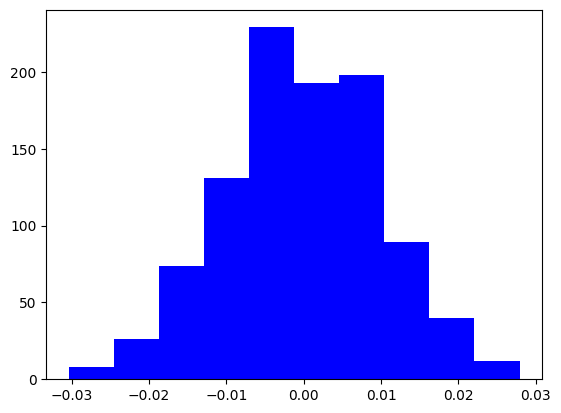

In [25]:
import matplotlib.pyplot as plt

plt.hist(dis_normal, color ="blue")
plt.show()

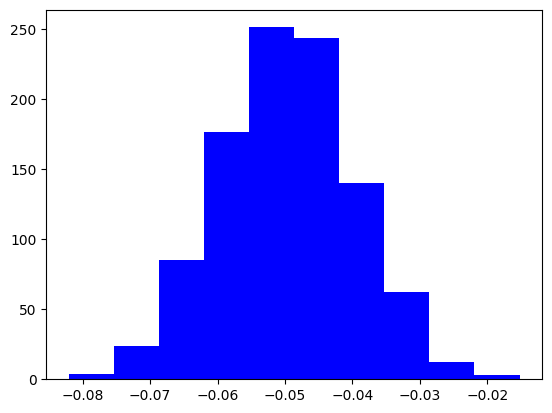

In [26]:
plt.hist(dis_lower, color ="blue")
plt.show()

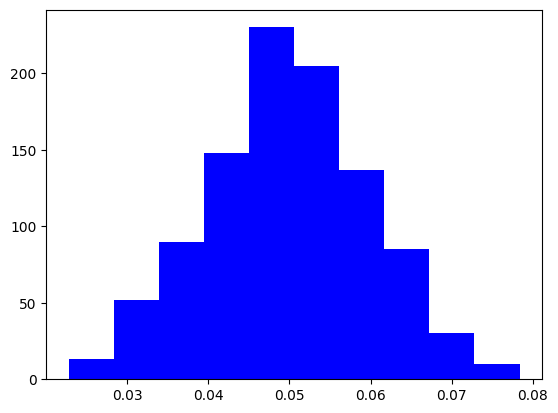

In [27]:
plt.hist(dis_upper, color ="blue")
plt.show()

In [28]:
#before executing the following cells, we need to reexecute the first few cells to de-standardize the values of the test set
#by re-creating the train-test-split
#perform train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_complete3, target_column, test_size = 0.08, random_state = 0)


In [29]:
#create probability around lower - by rows and columns
test_df_normal = X_test.copy()
for index, row in test_df_normal.iterrows():
    for column in numeric_predictors: 
        test_df_normal.at[index, column] = row[column]*(1+random.choice(dis_normal))

In [30]:
#create probability around lower - by rows and columns
test_df_lower = X_test.copy()
for index, row in test_df_lower.iterrows():
    for column in numeric_predictors: 
        test_df_lower.at[index, column] = row[column]*(1+random.choice(dis_lower))

In [31]:
#create probability around lower - by rows and columsn 
test_df_upper = X_test.copy()
for index, row in test_df_upper.iterrows():
    for column in numeric_predictors: 
        test_df_upper.at[index, column] = row[column]*(1+random.choice(dis_upper))

In [32]:
#normalize the data with a StandardScaler - performance regarding simple model is better, so we continue with the Standard Scaler!
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [33]:
#transforming the data with the StandardScaler
test_df_normal = sc.transform(test_df_normal)
test_df_lower = sc.transform(test_df_lower)
test_df_upper = sc.transform(test_df_upper)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [34]:
#creatine data frames and exporting for testing
test_df_lower = pd.DataFrame(test_df_lower)
test_df_normal = pd.DataFrame(test_df_normal)
test_df_upper = pd.DataFrame(test_df_upper)

test_df_lower.to_excel("test_df_lower.xlsx")
test_df_normal.to_excel("test_df_normal.xlsx")
test_df_upper.to_excel("test_df_upper.xlsx")

KeyboardInterrupt: 

In [ ]:
#creating predictions of all 3 datasets
y_normal = grid.predict(test_df_normal)
y_lower = grid.predict(test_df_lower)
y_upper = grid.predict(test_df_upper)

Calculate error metrics on the different sets.

In [ ]:
MSE_train = mean_squared_error(y_test, y_lower)
MAE_train = mean_absolute_error(y_test , y_lower)
print('Neural Net worst-case scenario  MAE = ', MAE_train)
print('Neural Net worst-case scenario  MSE = ', MSE_train)

Neural Net worst-case scenario  MAE =  3.2047687
Neural Net worst-case scenario  MSE =  143.38109

In [ ]:
MSE_train = mean_squared_error(y_test, y_normal)
MAE_train = mean_absolute_error(y_test , y_normal)
print('Neural Net normal scenario MAE = ', MAE_train)
print('Neural Net normal scenario  MSE = ', MSE_train)

Neural Net normal scenario MAE =  3.5158632
Neural Net normal scenario  MSE =  145.40828

In [ ]:
MSE_train = mean_squared_error(y_test, y_upper)
MAE_train = mean_absolute_error(y_test , y_upper)
print('Neural Net best-case scenario  MAE = ', MAE_train)
print('Neural Net best-case scenario MSE = ', MSE_train)

Neural Net best-case scenario  MAE =  6.114846
Neural Net best-case scenario MSE =  355.8377

In [ ]:
#original predictions on the test dataset, without the randomness introduced
y_pred = grid.predict(X_test)
MSE_train = mean_squared_error(y_test, y_pred)
MAE_train = mean_absolute_error(y_test , y_pred)
print('Neural Net test MAE = ', MAE_train)
print('Neural Net test MSE = ', MSE_train)

In [ ]:
y_lower

In [ ]:
y_normal

In [ ]:
y_pred

In [ ]:
y_upper

In [ ]:
y_test